## Simple Introduction to DFlat and It's Workflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import gc
from dflat.initialize import focusing_lens, Gaussian_lens
from dflat.metasurface import reverse_lookup_optimize, load_optical_model, export_geometry_to_comsol
from dflat.metasurface import build_transfer_targets, incident_field_to_amp_phase, load_field_table
from dflat.plot_utilities import mp_format
from dflat.propagation.propagators_legacy import PointSpreadFunction  # Using the legacy version as it takes wavelength as a forward input instead of initialization input

d:\PhD\Git\DFlat\.venv\Lib\site-packages\dflat\metasurface\load_utils.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


(1, 257, 257) (1, 257, 257) (1, 257, 257)


Text(0.5, 1.0, 'phase')

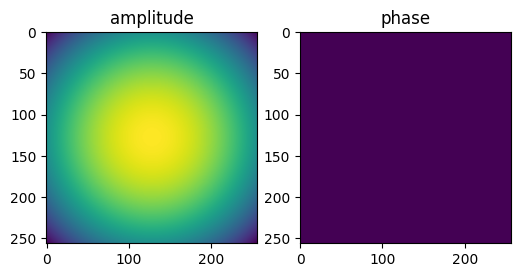

In [2]:
amp, phase, aperture = Gaussian_lens(
    in_size=[257,257],
    in_dx_m=[300e-9, 300e-9],
    wavelength_set_m=[600e-9],
    depth_set_m=[1e-3],
    waist_set_m=[1e-3]
)
# returns focusing profiles of shape [Z, Lam, H, W]
print(amp.shape, phase.shape, aperture.shape)

fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(amp[0]*aperture[0])
ax[0].set_title("amplitude")
ax[1].imshow(phase[0])
ax[1].set_title("phase")

Running optimization with device cuda
Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_Si3N4_U350H600\model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


Loss: 0.0375: 100%|██████████| 500/500 [00:10<00:00, 48.81it/s]       


Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_Si3N4_U350H600\model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


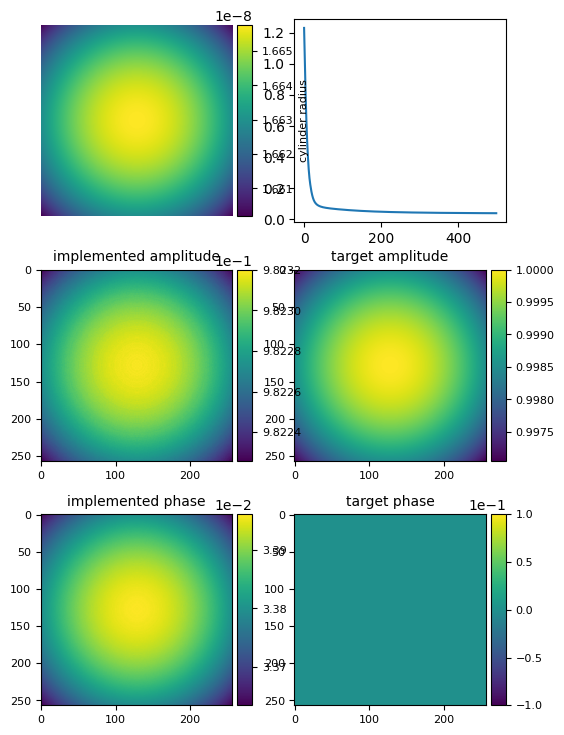

In [3]:
# Reverse look-up to find the metasurface that implements the target profile
model_name = "Nanocylinders_Si3N4_U350H600"

p_norm, p, err = reverse_lookup_optimize(
    amp[None,None],
    phase[None,None],
    [600e-9],
    model_name,
    lr=1e-1,
    err_thresh=1e-6,
    max_iter=500,
    opt_phase_only=False)

# As a check, lets call the optical model and see what this metasurface does vs what we desired
model = load_optical_model(model_name)
model = model.to("cuda")

est_amp, est_phase = model(p, np.array([600e-9]), pre_normalized=False)
est_amp = est_amp.detach().cpu().numpy()
est_phase = est_phase.detach().cpu().numpy()

fig, ax = plt.subplots(3,2, figsize=(6,9))
ax[0,0].imshow(p.squeeze())
mp_format.format_plot(fig, ax[0,0], addcolorbar=True, setAspect="equal", cbartitle="cylinder radius")
ax[0,0].axis('off')
ax[0,1].plot(err)
ax[1,0].imshow(est_amp.squeeze())
mp_format.format_plot(fig, ax[1,0], title="implemented amplitude", addcolorbar=True, setAspect="equal")
ax[1,1].imshow(amp.squeeze())
mp_format.format_plot(fig, ax[1,1], title="target amplitude",  addcolorbar=True, setAspect="equal")
ax[2,0].imshow(est_phase.squeeze())
mp_format.format_plot(fig, ax[2,0], title="implemented phase", addcolorbar=True, setAspect="equal")
ax[2,1].imshow(phase.squeeze())
mp_format.format_plot(fig, ax[2,1], title="target phase", addcolorbar=True, setAspect="equal")

In [4]:
print(p.shape, p.min(), p.max())

(1, 257, 257, 1) 1.6601948e-08 1.6657609e-08


In [ ]:
import mph
mph_client = mph.start(cores=4)
mph_model = mph_client.create("test_model")
comsol = export_geometry_to_comsol(
    p,
    model_name,
    mph_model=mph_model
    )

Exporting unit cells:  81%|████████  | 53563/66049 [2:14:42<64:19:45, 18.55s/it]

In [ ]:
comsol.save("metasurface.mph", format="Comsol")

In [12]:
mph_client.remove(mph_model)

In [4]:
est_phase = est_phase % (2*np.pi)
print(np.std(est_phase))

6.925313e-05


$$\eta=\frac{\left|\iint_{\mathcal{A}}E_{\mathrm{imp}}(x,y)E_{\mathrm{tgt}}^*(x,y)dxdy\right|^2}{\left(\iint_{\mathcal{A}}|E_{\mathrm{imp}}|^2dxdy\right)\left(\iint_{\mathcal{A}}|E_{\mathrm{tgt}}|^2dxdy\right)}$$

In [5]:
# complex fields
E_tgt = amp.squeeze() * np.exp(1j * phase.squeeze())
E_imp = est_amp.squeeze() * np.exp(1j * est_phase.squeeze())

num = np.sum(E_imp * np.conj(E_tgt))
den = np.sqrt(np.sum(np.abs(E_imp)**2) * np.sum(np.abs(E_tgt)**2))
eta = np.abs(num / den)**2   # scalar in [0, 1]
print(f"Mode-overlap efficiency: {eta*100:.10f}%")

Mode-overlap efficiency: 99.9999601439%


In [18]:
df = load_field_table("test_field_data.txt")  # Load pre-saved field table for propagation test
print(df)

Ex = df["ExRe [V/m]"] + 1j*df["ExIm [V/m]"]
Ey = df["EyRe [V/m]"] + 1j*df["EyIm [V/m]"]
Ez = df["EzRe [V/m]"] + 1j*df["EzIm [V/m]"]

# Reshape to 2D arrays based on x and y coordinates
x_unique = df["x [um]"].unique()
y_unique = df["y [um]"].unique()
ny = len(y_unique)
nx = len(x_unique)

Ex = Ex.values.reshape(ny, nx)
Ey = Ey.values.reshape(ny, nx)
Ez = Ez.values.reshape(ny, nx)

print(f"Field shapes: Ex={Ex.shape}, Ey={Ey.shape}, Ez={Ez.shape}")
print(f"Grid dimensions: {nx} x positions, {ny} y positions")


      x [um]  y [um]     z [um]  ExRe [V/m]  ExIm [V/m]  EyRe [V/m]  \
0       -135    -200  181.02698   13892.904 -10456.2630  489.096310   
1       -125    -200  181.02698   14661.605 -10022.3030  266.428830   
2       -115    -200  181.02698   15917.681  -9225.8135   75.410492   
3       -105    -200  181.02698   17339.869  -8294.7529 -101.793370   
4        -95    -200  181.02698   18578.895  -7291.3267 -233.528590   
...      ...     ...        ...         ...         ...         ...   
1143      95     200  181.02698   18578.895  -7291.3267 -233.528590   
1144     105     200  181.02698   17339.869  -8294.7529 -101.793370   
1145     115     200  181.02698   15917.681  -9225.8135   75.410492   
1146     125     200  181.02698   14661.605 -10022.3030  266.428830   
1147     135     200  181.02698   13892.904 -10456.2630  489.096310   

      EyIm [V/m]  EzRe [V/m]  EzIm [V/m]  
0      2034.5439   7846.2681  -9441.8252  
1      1972.3324   8302.2197  -8250.3896  
2      1873.2574  

In [36]:
# Custom ASM (Angular Spectrum Method) propagator
def propagate_field_asm(field, wavelength, dx, dy, distance, out_size=None, out_dx=None):
    """
    Propagate a complex field using the Angular Spectrum Method.
    
    Parameters:
    -----------
    field : numpy.ndarray (complex)
        2D complex field to propagate
    wavelength : float
        Wavelength in meters
    dx, dy : float
        Grid spacing in x and y directions (meters)
    distance : float
        Propagation distance (meters)
    out_size : tuple of int, optional
        Output grid size as (ny_out, nx_out). If None, uses input size.
    out_dx : tuple of float, optional
        Output grid spacing as (dy_out, dx_out). If None, uses input spacing.
    
    Returns:
    --------
    field_prop : numpy.ndarray (complex)
        Propagated complex field
    """
    ny, nx = field.shape
    
    # Frequency coordinates
    fx = np.fft.fftfreq(nx, dx)  # spatial frequencies in x
    fy = np.fft.fftfreq(ny, dy)  # spatial frequencies in y
    FX, FY = np.meshgrid(fx, fy)
    
    # Wave number
    k = 2 * np.pi / wavelength
    
    # Transfer function H(fx, fy) = exp(i * kz * z)
    # where kz = sqrt(k^2 - (2*pi*fx)^2 - (2*pi*fy)^2)
    k_squared = k**2
    kx_squared = (2 * np.pi * FX)**2
    ky_squared = (2 * np.pi * FY)**2
    
    # Calculate kz with evanescent wave handling
    kz_squared = k_squared - kx_squared - ky_squared
    
    # For evanescent waves (kz_squared < 0), we get exponential decay
    kz = np.sqrt(kz_squared + 0j)  # Complex sqrt handles both propagating and evanescent
    
    # Transfer function
    H = np.exp(1j * kz * distance)
    
    # Apply evanescent wave cutoff for numerical stability
    # Evanescent waves decay exponentially, so we can suppress them
    evanescent_mask = kz_squared < 0
    H[evanescent_mask] = 0  # or use: H[evanescent_mask] *= np.exp(-np.abs(kz[evanescent_mask].imag) * distance)
    
    # Propagate: F^-1{ F{field} * H }
    field_fft = np.fft.fft2(field)
    field_fft_prop = field_fft * H
    field_prop = np.fft.ifft2(field_fft_prop)
    
    # Resample to output grid if specified
    if out_size is not None or out_dx is not None:
        # Use input values if not specified
        if out_size is None:
            out_size = (ny, nx)
        if out_dx is None:
            out_dx = (dy, dx)
        
        ny_out, nx_out = out_size
        dy_out, dx_out = out_dx
        
        # Create input and output coordinate grids
        x_in = (np.arange(nx) - nx // 2) * dx
        y_in = (np.arange(ny) - ny // 2) * dy
        
        x_out = (np.arange(nx_out) - nx_out // 2) * dx_out
        y_out = (np.arange(ny_out) - ny_out // 2) * dy_out
        
        # Use scipy interpolation for resampling
        from scipy.interpolate import RectBivariateSpline
        
        # Shift field to have zero at corner for interpolation
        field_prop_shifted = np.fft.ifftshift(field_prop)
        x_in_shifted = np.arange(nx) * dx
        y_in_shifted = np.arange(ny) * dy
        x_out_shifted = (np.arange(nx_out) - nx_out // 2 + nx // 2) * dx_out
        y_out_shifted = (np.arange(ny_out) - ny_out // 2 + ny // 2) * dy_out
        
        # Interpolate real and imaginary parts separately
        interp_real = RectBivariateSpline(y_in_shifted, x_in_shifted, field_prop_shifted.real, kx=1, ky=1)
        interp_imag = RectBivariateSpline(y_in_shifted, x_in_shifted, field_prop_shifted.imag, kx=1, ky=1)
        
        field_prop_real = interp_real(y_out_shifted, x_out_shifted)
        field_prop_imag = interp_imag(y_out_shifted, x_out_shifted)
        field_prop = field_prop_real + 1j * field_prop_imag
    
    return field_prop


# Propagate the field to the lens location
# Define propagation distance
d = 1e-3  # 1 mm propagation distance

# Define wavelength (adjust to match your field data)
wavelength = 3e-5 # 600 nm

# Get the actual grid spacing from the data file
x_coords = df["x [um]"].unique()
y_coords = df["y [um]"].unique()
dx = np.abs(x_coords[1] - x_coords[0]) * 1e-6  # Convert from microns to meters
dy = np.abs(y_coords[1] - y_coords[0]) * 1e-6  # Convert from microns to meters

# Define output grid 
out_size = [257,257]
out_dx = [600e-9, 600e-9]  # 600 nm spacing


print(f"Input grid: {Ex.shape}, spacing: dx={dx*1e6:.2f} μm, dy={dy*1e6:.2f} μm")
print(f"Wavelength: {wavelength*1e9:.1f} nm")
print(f"Propagation distance: {d*1e3:.2f} mm")
if out_size is not None:
    print(f"Output grid size: {out_size}")
if out_dx is not None:
    print(f"Output grid spacing: dx={out_dx[1]*1e6:.2f} μm, dy={out_dx[0]*1e6:.2f} μm")

# Propagate each field component using our custom ASM
Ex_prop = propagate_field_asm(Ex, wavelength, dx, dy, d, out_size, out_dx)
Ey_prop = propagate_field_asm(Ey, wavelength, dx, dy, d, out_size, out_dx)
Ez_prop = propagate_field_asm(Ez, wavelength, dx, dy, d, out_size, out_dx)

print(f"\nPropagated field shapes: Ex={Ex_prop.shape}, Ey={Ey_prop.shape}, Ez={Ez_prop.shape}")
print(f"Original field max amplitude: |Ex|={np.abs(Ex).max():.2e}")
print(f"Propagated field max amplitude: |Ex_prop|={np.abs(Ex_prop).max():.2e}")

Input grid: (41, 28), spacing: dx=10.00 μm, dy=10.00 μm
Wavelength: 30000.0 nm
Propagation distance: 1.00 mm
Output grid size: [257, 257]
Output grid spacing: dx=0.60 μm, dy=0.60 μm

Propagated field shapes: Ex=(257, 257), Ey=(257, 257), Ez=(257, 257)
Original field max amplitude: |Ex|=5.79e+04
Propagated field max amplitude: |Ex_prop|=7.87e+04


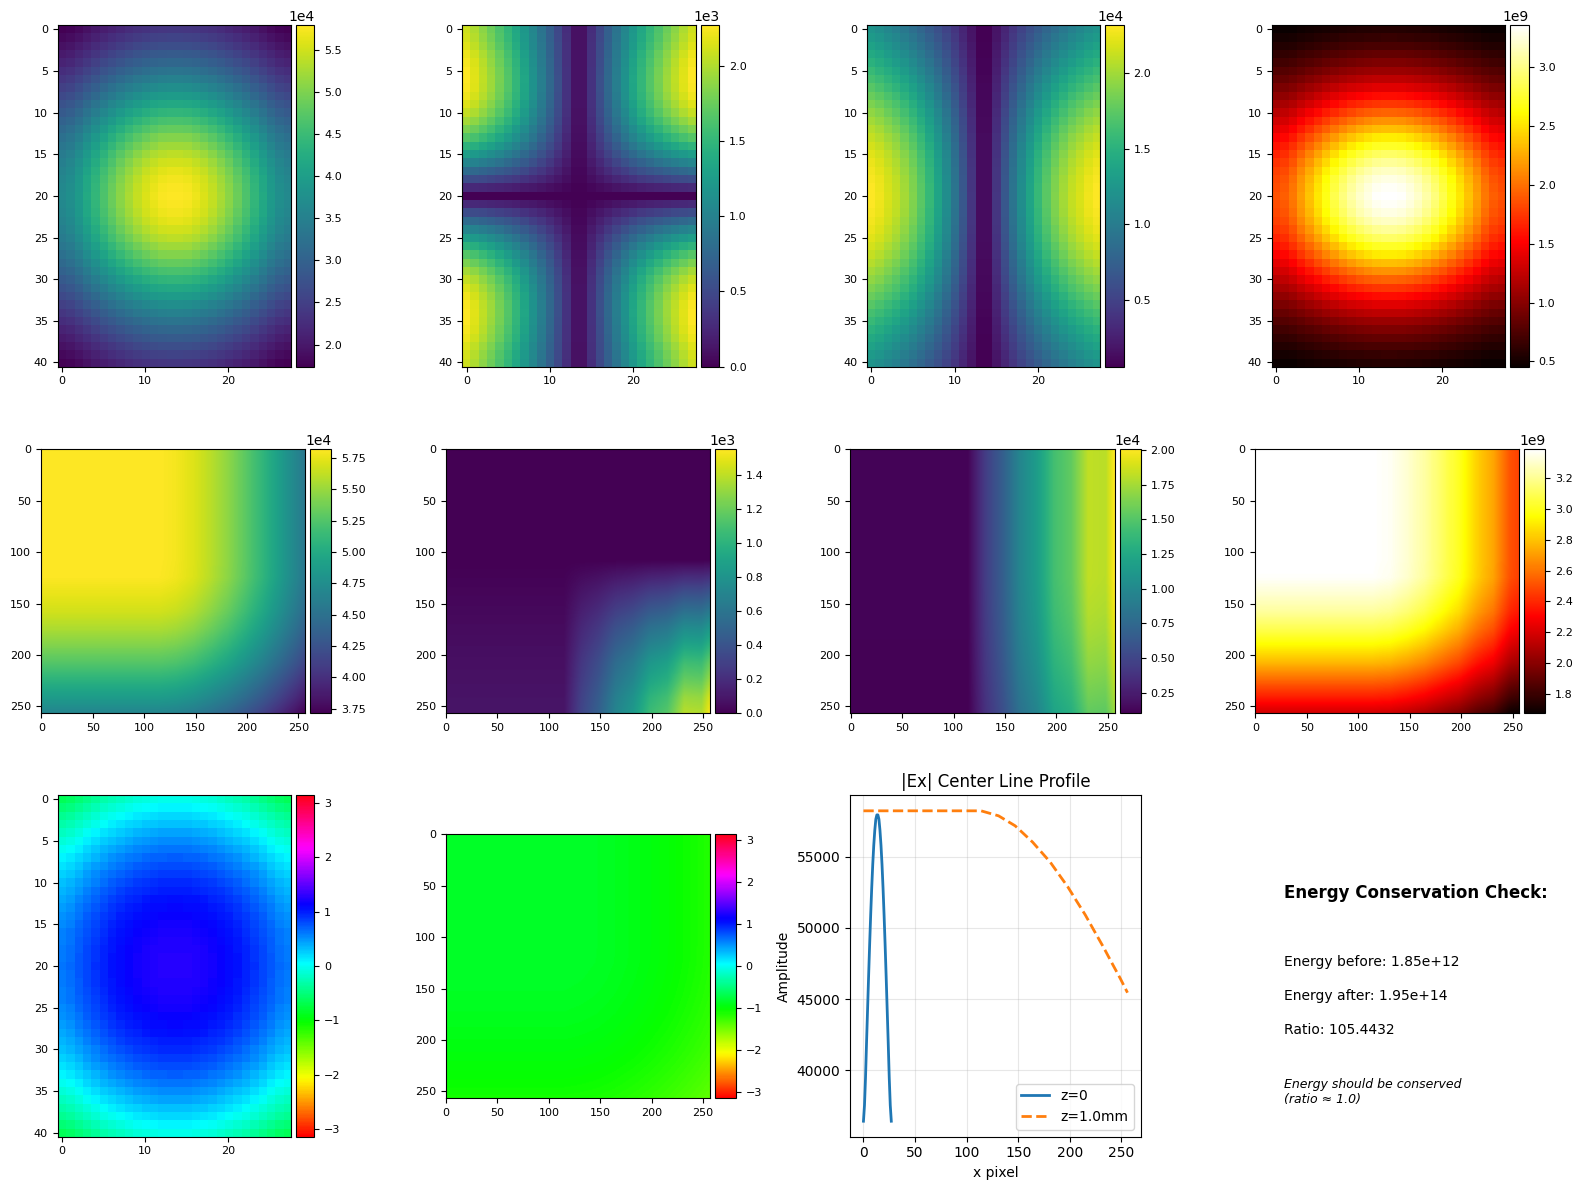


Energy conservation: 105.443233 (should be close to 1.0)


In [23]:
# Visualize the field before and after propagation
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

# Row 1: Original field amplitudes at z=0
ax[0,0].imshow(np.abs(Ex), cmap='viridis')
ax[0,0].set_title('|Ex| at z=0')
mp_format.format_plot(fig, ax[0,0], addcolorbar=True, setAspect="equal")

ax[0,1].imshow(np.abs(Ey), cmap='viridis')
ax[0,1].set_title('|Ey| at z=0')
mp_format.format_plot(fig, ax[0,1], addcolorbar=True, setAspect="equal")

ax[0,2].imshow(np.abs(Ez), cmap='viridis')
ax[0,2].set_title('|Ez| at z=0')
mp_format.format_plot(fig, ax[0,2], addcolorbar=True, setAspect="equal")

ax[0,3].imshow(np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2, cmap='hot')
ax[0,3].set_title('Total Intensity at z=0')
mp_format.format_plot(fig, ax[0,3], addcolorbar=True, setAspect="equal")

# Row 2: Propagated field amplitudes at distance d
ax[1,0].imshow(np.abs(Ex_prop), cmap='viridis')
ax[1,0].set_title(f'|Ex| at z={d*1e3:.2f}mm')
mp_format.format_plot(fig, ax[1,0], addcolorbar=True, setAspect="equal")

ax[1,1].imshow(np.abs(Ey_prop), cmap='viridis')
ax[1,1].set_title(f'|Ey| at z={d*1e3:.2f}mm')
mp_format.format_plot(fig, ax[1,1], addcolorbar=True, setAspect="equal")

ax[1,2].imshow(np.abs(Ez_prop), cmap='viridis')
ax[1,2].set_title(f'|Ez| at z={d*1e3:.2f}mm')
mp_format.format_plot(fig, ax[1,2], addcolorbar=True, setAspect="equal")

ax[1,3].imshow(np.abs(Ex_prop)**2 + np.abs(Ey_prop)**2 + np.abs(Ez_prop)**2, cmap='hot')
ax[1,3].set_title(f'Total Intensity at z={d*1e3:.2f}mm')
mp_format.format_plot(fig, ax[1,3], addcolorbar=True, setAspect="equal")

# Row 3: Phase information
ax[2,0].imshow(np.angle(Ex), cmap='hsv', vmin=-np.pi, vmax=np.pi)
ax[2,0].set_title('Phase of Ex at z=0')
mp_format.format_plot(fig, ax[2,0], addcolorbar=True, setAspect="equal")

ax[2,1].imshow(np.angle(Ex_prop), cmap='hsv', vmin=-np.pi, vmax=np.pi)
ax[2,1].set_title(f'Phase of Ex at z={d*1e3:.2f}mm')
mp_format.format_plot(fig, ax[2,1], addcolorbar=True, setAspect="equal")

# Plot center line profiles
center_y = Ex.shape[0] // 2
ax[2,2].plot(np.abs(Ex[center_y, :]), label='z=0', linewidth=2)
ax[2,2].plot(np.abs(Ex_prop[center_y, :]), label=f'z={d*1e3:.1f}mm', linewidth=2, linestyle='--')
ax[2,2].set_title('|Ex| Center Line Profile')
ax[2,2].set_xlabel('x pixel')
ax[2,2].set_ylabel('Amplitude')
ax[2,2].legend()
ax[2,2].grid(True, alpha=0.3)

# Energy conservation check
energy_before = np.sum(np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2)
energy_after = np.sum(np.abs(Ex_prop)**2 + np.abs(Ey_prop)**2 + np.abs(Ez_prop)**2)
energy_ratio = energy_after / energy_before

ax[2,3].text(0.1, 0.7, f'Energy Conservation Check:', fontsize=12, fontweight='bold')
ax[2,3].text(0.1, 0.5, f'Energy before: {energy_before:.2e}', fontsize=10)
ax[2,3].text(0.1, 0.4, f'Energy after: {energy_after:.2e}', fontsize=10)
ax[2,3].text(0.1, 0.3, f'Ratio: {energy_ratio:.4f}', fontsize=10)
ax[2,3].text(0.1, 0.1, f'Energy should be conserved\n(ratio ≈ 1.0)', fontsize=9, style='italic')
ax[2,3].axis('off')

plt.tight_layout()
plt.show()

print(f"\nEnergy conservation: {energy_ratio:.6f} (should be close to 1.0)")

In [37]:
amp_in, phase_in = incident_field_to_amp_phase(Ex_prop, Ey_prop, Ez_prop, pol_vector=(1,1,1))
print(f"Input field amplitude range: {amp_in.min()} to {amp_in.max()}")

# Build transfer targets
amp_tgt, phase_tgt, aperture = Gaussian_lens(
    in_size=[257,257],
    in_dx_m=[600e-9, 600e-9],
    wavelength_set_m=[3e-5],
    depth_set_m=[1e-3],
    waist_set_m=[1e-3]
)

amp_target, phase_target, mask = build_transfer_targets(
    amp_tgt,
    phase_tgt,
    amp_in,
    phase_in
)
print(f"Transfer target shapes: {amp_target.detach().cpu().numpy().shape}, {phase_target.detach().cpu().numpy().shape}")

Input field amplitude range: 15877.716796875 to 49112.41796875
Transfer target shapes: (1, 257, 257), (1, 257, 257)


Running optimization with device cuda
Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_Si3N4_U350H600\model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


Loss: 0.2835: 100%|██████████| 500/500 [00:08<00:00, 56.61it/s]


Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_Si3N4_U350H600\model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


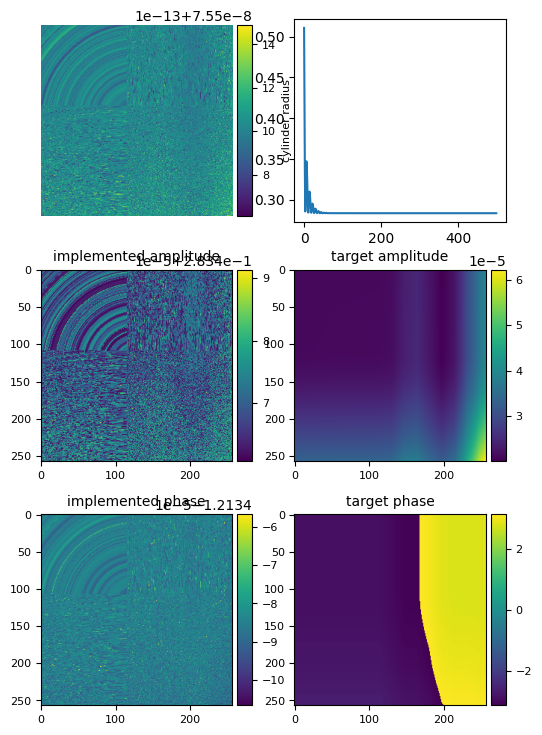

In [38]:
# Reverse look-up to find the metasurface that implements the target profile
model_name = "Nanocylinders_Si3N4_U350H600"

amp_target = amp_target.detach().cpu().numpy()
phase_target = phase_target.detach().cpu().numpy()

p_norm, p, err = reverse_lookup_optimize(
    amp_target[None,None],
    phase_target[None,None],
    [3e-5],
    model_name,
    lr=1e-1,
    err_thresh=1e-6,
    max_iter=500,
    opt_phase_only=False)

# As a check, lets call the optical model and see what this metasurface does vs what we desired
model = load_optical_model(model_name)
model = model.to("cuda")

est_amp, est_phase = model(p, np.array([3e-5]), pre_normalized=False)
est_amp = est_amp.detach().cpu().numpy()
est_phase = est_phase.detach().cpu().numpy()

fig, ax = plt.subplots(3,2, figsize=(6,9))
ax[0,0].imshow(p.squeeze())
mp_format.format_plot(fig, ax[0,0], addcolorbar=True, setAspect="equal", cbartitle="cylinder radius")
ax[0,0].axis('off')
ax[0,1].plot(err)
ax[1,0].imshow(est_amp.squeeze())
mp_format.format_plot(fig, ax[1,0], title="implemented amplitude", addcolorbar=True, setAspect="equal")
ax[1,1].imshow(amp_target.squeeze())
mp_format.format_plot(fig, ax[1,1], title="target amplitude",  addcolorbar=True, setAspect="equal")
ax[2,0].imshow(est_phase.squeeze())
mp_format.format_plot(fig, ax[2,0], title="implemented phase", addcolorbar=True, setAspect="equal")
ax[2,1].imshow(phase_target.squeeze())
mp_format.format_plot(fig, ax[2,1], title="target phase", addcolorbar=True, setAspect="equal")

(1, 257, 257) (1, 257, 257) (1, 257, 257)


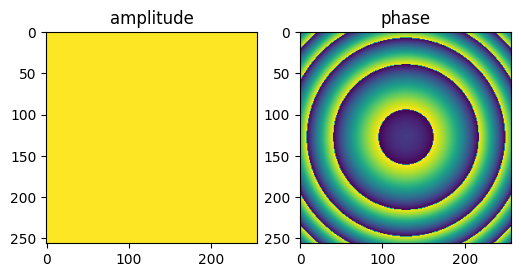

In [ ]:
amp, phase, aperture = focusing_lens(
    in_size=[257,257],
    in_dx_m=[300e-9, 300e-9],
    wavelength_set_m=[600e-9],
    depth_set_m=[1e-3],
    fshift_set_m=[[0.0, 0.0]],
    out_distance_m=1e-3,
    aperture_radius_m=None,
    radial_symmetry=False
)
# returns focusing profiles of shape [Z, Lam, H, W]
print(amp.shape, phase.shape, aperture.shape)

fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(amp[0]*aperture[0], vmin=0, vmax=1)
ax[0].set_title("amplitude")
ax[1].imshow(phase[0])
ax[1].set_title("phase")

Running optimization with device cuda
Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_TiO2_U300H600/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


Loss: 0.1864: 100%|██████████| 500/500 [00:06<00:00, 76.78it/s]       


Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_TiO2_U300H600/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


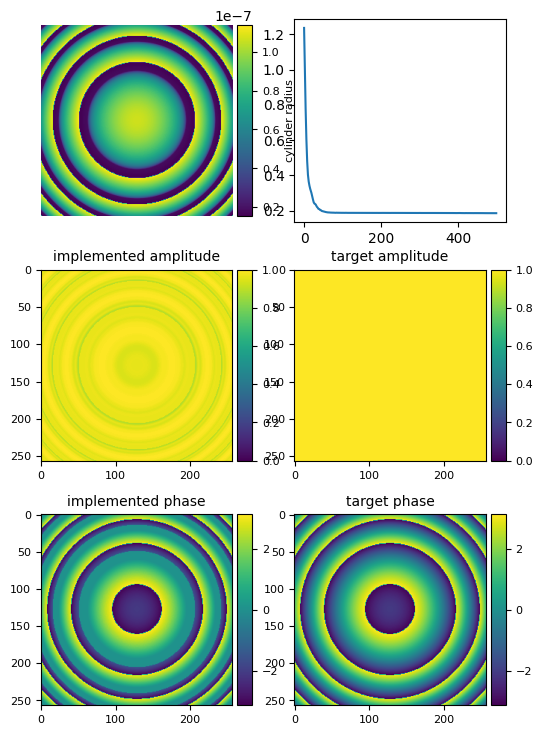

In [3]:
# Reverse look-up to find the metasurface that implements the target profile
model_name = "Nanocylinders_TiO2_U300H600"

p_norm, p, err = reverse_lookup_optimize(
    amp[None,None],
    phase[None,None],
    [600e-9],
    model_name,
    lr=1e-1,
    err_thresh=1e-6,
    max_iter=500,
    opt_phase_only=False)

# As a check, lets call the optical model and see what this metasurface does vs what we desired
model = load_optical_model(model_name)
model = model.to("cuda")

est_amp, est_phase = model(p, np.array([600e-9]), pre_normalized=False)
est_amp = est_amp.detach().cpu().numpy()
est_phase = est_phase.detach().cpu().numpy()

fig, ax = plt.subplots(3,2, figsize=(6,9))
ax[0,0].imshow(p.squeeze())
mp_format.format_plot(fig, ax[0,0], addcolorbar=True, setAspect="equal", cbartitle="cylinder radius")
ax[0,0].axis('off')
ax[0,1].plot(err)
ax[1,0].imshow(est_amp.squeeze(), vmin=0, vmax=1)
mp_format.format_plot(fig, ax[1,0], title="implemented amplitude", addcolorbar=True, setAspect="equal")
ax[1,1].imshow(amp.squeeze(), vmin=0, vmax=1)
mp_format.format_plot(fig, ax[1,1], title="target amplitude",  addcolorbar=True, setAspect="equal")
ax[2,0].imshow(est_phase.squeeze())
mp_format.format_plot(fig, ax[2,0], title="implemented phase", addcolorbar=True, setAspect="equal")
ax[2,1].imshow(phase.squeeze())
mp_format.format_plot(fig, ax[2,1], title="target phase", addcolorbar=True, setAspect="equal")

In [4]:
# Compute the point-spread function for this lens for different conditions
PSF = PointSpreadFunction(
    in_size=[257, 257],
    in_dx_m=[300e-9, 300e-9],
    out_distance_m=1e-3,
    out_size=[512, 512],
    out_dx_m=[500e-9, 500e-9],
    out_resample_dx_m=None,
    radial_symmetry=False,
    diffraction_engine="ASM")

ps_locs = [[0.0, 0.0, 5e-4], [0.0, 0.0, 1e-3], [0.0, 0.0, 5e-3]]
sim_wl = [500e-9, 600e-9, 700e-9]

intensity, phase = PSF(
    torch.tensor(est_amp, dtype=torch.float32, device='cuda'),
    torch.tensor(est_phase, dtype=torch.float32, device='cuda'),
    sim_wl,
    ps_locs,
    aperture=None,
    normalize_to_aperture=True)
intensity = intensity.cpu().numpy()
phase = phase.cpu().numpy()

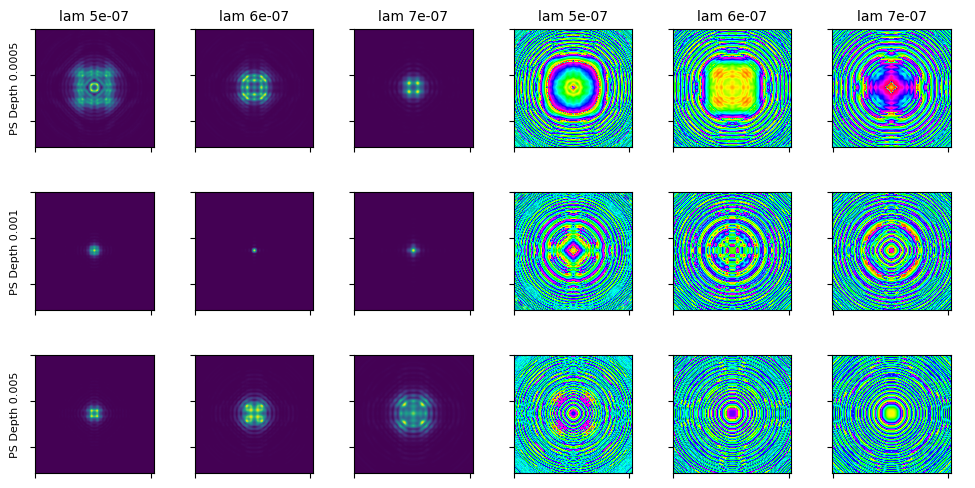

In [5]:
fig, ax = plt.subplots(3, 6, figsize=(12,6))
for z in range(3):
    for l in range(3):
        ax[z,l].imshow(intensity[0,0, z, l,:,:])
        mp_format.format_plot(
            fig, 
            ax[z,l],
            title= f"lam {sim_wl[l]}" if z==0 else "",
            rmvxLabel=True,
            rmvyLabel=True, 
            setAspect="equal")
        
    for l in np.arange(3,6,1):
        ax[z,l].imshow(phase[0,0, z, l-3,:,:], cmap='hsv')
        mp_format.format_plot(
            fig, 
            ax[z,l],
            title= f"lam {sim_wl[l-3]}" if z==0 else "",
            rmvxLabel=True,
            rmvyLabel=True, 
            setAspect="equal")
    ax[z,0].set_ylabel(f"PS Depth {ps_locs[z][2]}")

In [ ]:
# Write this lens to a gds file for fabrication
pfab = p.squeeze(0)
mask = np.ones(pfab.shape[0:2])
cell_size = [300e-9, 300e-9]
block_size =[300e-9, 300e-9] # This can be used to repeat the cell as a larger block

from dflat.GDSII.assemble import assemble_cylinder_gds
assemble_cylinder_gds(pfab, mask, cell_size, block_size, savepath="./file.gds")

Writing metasurface shapes to GDS File


  0%|          | 0/257 [00:00<?, ?it/s]

100%|██████████| 257/257 [00:02<00:00, 128.09it/s]


Completed writing and saving metasurface GDS File: Time:  2.311383008956909


In [7]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [8]:
import matplotlib.pyplot as plt
import mat73
from scipy import interpolate
import numpy as np
import torch
from einops import rearrange

from dflat.initialize import focusing_lens
from dflat.metasurface import reverse_lookup_optimize, load_optical_model
from dflat.propagation.propagators_legacy import PointSpreadFunction # Using the legacy version as it takes wavelength as a forward input instead of initialization input
from dflat.render import hsi_to_rgb
from dflat.plot_utilities import format_plot
from dflat.render import Fronto_Planar_Renderer_Incoherent

In [9]:
settings = {
    "in_size": [513, 513],
    "in_dx_m": [10*300e-9, 10*300e-9],
    "wavelength_set_m": [550e-9],
    "depth_set_m": [1e-2],
    "fshift_set_m": [[0.0, 0.0]],
    "out_distance_m": 1e-2,
    "aperture_radius_m": None,
    "radial_symmetry": True
    }
amp, phase, aperture = focusing_lens(**settings)
print(amp.shape, phase.shape, aperture.shape)
#  Phase, and Aperture profiles of shape [Z, Lam, H, W]

# Reverse look-up to find the metasurface that implements the target profile
model_name = "Nanocylinders_TiO2_U300H600"
p_norm, p, err = reverse_lookup_optimize(
    amp[None, None],
    phase[None, None],
    [550e-9],
    model_name,
    lr=1e-1,
    err_thresh=1e-6,
    max_iter=500,
    opt_phase_only=False)
print(p.shape)
# [B, H, W, D] where D is the number of shape parameters. 

# Predict the broadband phase and amplitude imparted by this collection of meta-atoms
model = load_optical_model(model_name)
model = model.to("cuda")
sim_wl = np.linspace(400e-9, 700e-9, 31)
est_amp, est_phase = model(p, sim_wl, pre_normalized=False)
print(est_amp.shape, est_phase.shape) 
# [B, pol, Lam, H, W] where pol is 1 or 2

# Compute the point spread function given this broadband stack of field amplitude and phases
PSF = PointSpreadFunction(
    in_size=[513, 513],
    in_dx_m=[10*300e-9, 10*300e-9],
    out_distance_m=1e-2,
    out_size=[512, 512],
    out_dx_m=[5e-6,5e-6],
    out_resample_dx_m=None,
    radial_symmetry=True,
    diffraction_engine="ASM")
ps_locs = [[0.0, 0.0, 1e-2]]

psf_intensity, _ = PSF(
    est_amp.to(dtype=torch.float32, device='cuda'),
    est_phase.to(dtype=torch.float32, device='cuda'),
    sim_wl,
    ps_locs,
    aperture=None,
    normalize_to_aperture=True)
print(psf_intensity.shape)
# shape [B P Z L H W]

(1, 1, 257) (1, 1, 257) (1, 1, 257)
Running optimization with device cuda
Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_TiO2_U300H600/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys


Loss: 0.1220: 100%|██████████| 500/500 [00:02<00:00, 241.85it/s]


(1, 1, 257, 1)
Target Module: dflat.metasurface.optical_model.NeuralCells
Note: trainable_model key in NeuralCells is deprecated. Model will be set to requires_grad.
Target Module: dflat.metasurface.nn_siren.SirenNet
Target: dflat.metasurface.optical_model.NeuralCells Loading from checkpoint DFlat/Models/Nanocylinders_TiO2_U300H600/model.ckpt as strict=True
Restored dflat.metasurface.optical_model.NeuralCells with 0 missing and 0 unexpected keys
torch.Size([1, 1, 31, 1, 257]) torch.Size([1, 1, 31, 1, 257])
torch.Size([1, 1, 1, 31, 512, 512])
